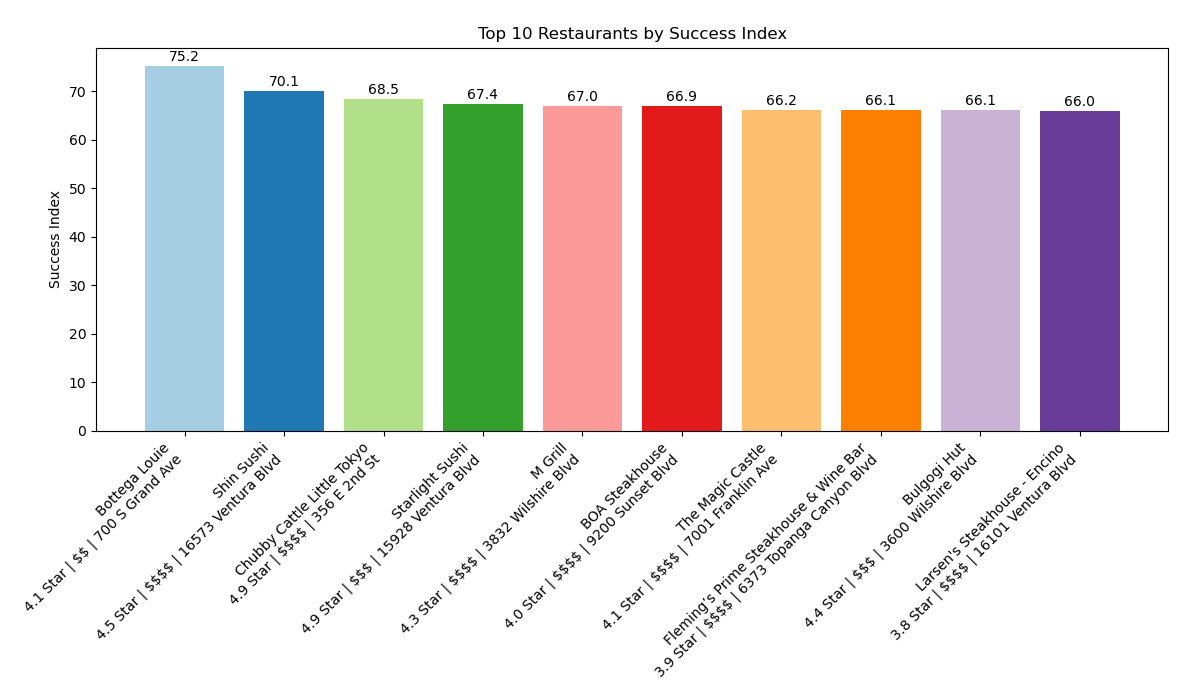

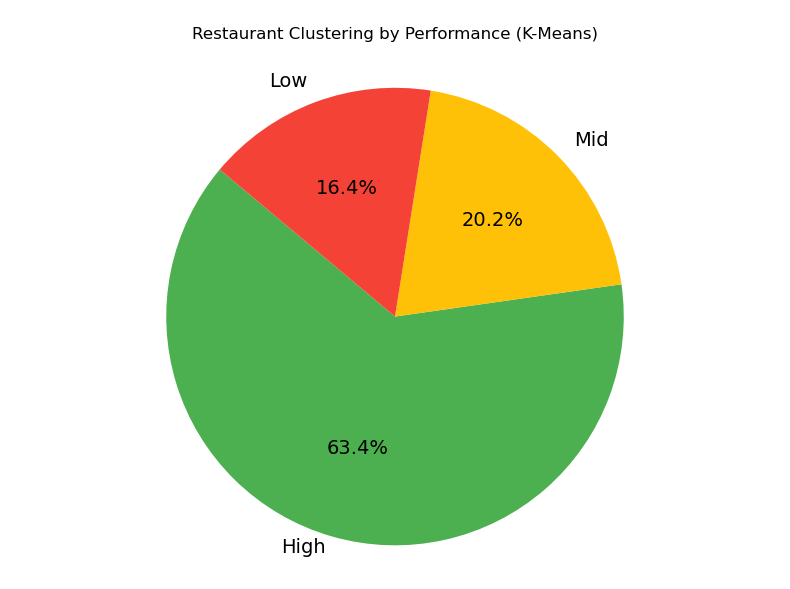

In [7]:
import sqlite3
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Load restaurant-level data
conn = sqlite3.connect("../db/database_sqlite.db")
query = """
SELECT
    Restaurant_Info_ID,
    Restaurant_Name,
    Rating,
    Review_Count,
    Score,
    Price,
    Total_Employer_Establishments,
    Restaurant_Address
FROM Combined_Restaurant_View
WHERE Rating IS NOT NULL
  AND Review_Count IS NOT NULL
  AND Score IS NOT NULL
  AND Price IS NOT NULL
  AND Total_Employer_Establishments IS NOT NULL
  AND Restaurant_Address IS NOT NULL
"""
df_rest = pd.read_sql_query(query, conn)
conn.close()

# Encode price levels
price_map = {'$': 1, '$$': 2, '$$$': 3, '$$$$': 4}
df_rest['Price_Encoded'] = df_rest['Price'].map(price_map)

# Normalize selected features
scaler = MinMaxScaler()
df_rest[['norm_rating', 'norm_reviews', 'norm_score', 'norm_price', 'norm_employers']] = (
    scaler.fit_transform(
        df_rest[['Rating', 'Review_Count', 'Score', 'Price_Encoded', 'Total_Employer_Establishments']]
    )
)

# Compute success index
df_rest['Success_Index'] = (
    0.30 * df_rest['norm_rating'] +
    0.25 * df_rest['norm_reviews'] +
    0.20 * df_rest['norm_score'] +
    0.15 * df_rest['norm_price'] +
    0.10 * df_rest['norm_employers']
) * 100

# Select top 10 restaurants
top_restaurants = (
    df_rest.sort_values(by='Success_Index', ascending=False)
    .drop_duplicates(subset='Restaurant_Info_ID')
    .head(10)
    .copy()
)
top_restaurants.reset_index(drop=True, inplace=True)

# Build x-axis labels
top_restaurants['Label'] = top_restaurants.apply(
    lambda row: (
        f"{row['Restaurant_Name']}\n"
        f"{row['Rating']} Star | {row['Price'].replace('$', r'\$')} | {row['Restaurant_Address']}"
    ),
    axis=1
)

# Plot top restaurants
plt.figure(figsize=(12, 7))
bars = plt.bar(
    top_restaurants['Label'],
    top_restaurants['Success_Index'],
    color=plt.cm.Paired.colors[:10]
)

# Add value labels
for i, bar in enumerate(bars):
    score = top_restaurants.iloc[i]['Success_Index']
    plt.text(
        bar.get_x() + bar.get_width() / 2.0,
        bar.get_height() + 1,
        f"{score:.1f}",
        ha='center',
        fontsize=10
    )

plt.title("\nTop 10 Restaurants by Success Index")
plt.ylabel("Success Index")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig("6.3. top_10_restaurants_success_index_5_features.png", dpi=300)
plt.show()

# K-Means clustering
features = df_rest[['norm_rating', 'norm_reviews', 'norm_score', 'norm_price', 'norm_employers']]
kmeans = KMeans(n_clusters=3, random_state=42)
df_rest['Cluster'] = kmeans.fit_predict(features)

# Relabel clusters by mean rating
cluster_means = df_rest.groupby('Cluster')['Rating'].mean().sort_values(ascending=False)
cluster_labels = {old: new for new, old in enumerate(cluster_means.index)}
df_rest['Cluster_Labeled'] = df_rest['Cluster'].map(cluster_labels)
df_rest['Cluster_Name'] = df_rest['Cluster_Labeled'].map({0: 'High\n', 1: 'Mid', 2: 'Low'})

# Plot cluster distribution
cluster_counts = (
    df_rest['Cluster_Name']
    .value_counts()
    .reindex(['High\n', 'Mid', 'Low'])
    .fillna(0)
)

plt.figure(figsize=(8, 6))
plt.pie(
    cluster_counts,
    labels=cluster_counts.index,
    autopct='%1.1f%%',
    startangle=140,
    colors=['#4CAF50', '#FFC107', '#F44336'],
    textprops={'fontsize': 14}
)
plt.title("\nRestaurant Clustering by Performance (K-Means)\n")
plt.axis('equal')
plt.tight_layout()
plt.savefig(
    "6.3. restaurant_cluster_distribution_kmeans.png",
    dpi=300,
    bbox_inches='tight'
)
plt.show()